In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [158]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
# df = df[["datetime","power_production_wind_avg"]]
# shift column 'power_production_wind_avg' to first position
first_column = df.pop('power_production_wind_avg')
df.insert(0, 'power_production_wind_avg', first_column)

day = 24*60*60
year = (365.2425)*day

df['sin_hour_of_day'] = np.sin(df["timestamp"] * (2 * np.pi / day))
df['cos_hour_of_day'] = np.cos(df["timestamp"] * (2 * np.pi / day))
df['sin_day_of_year'] = np.sin(df["timestamp"] * (2 * np.pi / year))
df['cos_day_of_year'] = np.cos(df["timestamp"] * (2 * np.pi / year))

df=df.dropna(axis=1)
y=df.drop(["datetime","timestamp","created_at","updated_at","zone_name","production_sources"],axis=1)

#y=(y-y.min())/(y.max()-y.min())
y=(y-y.mean())/y.std()
y=y.dropna(axis=1)
y.tail()
 


,carbon_intensity_avg,carbon_intensity_direct_avg,carbon_intensity_production_avg,total_production_avg,total_storage_avg,total_discharge_avg,total_import_avg,total_export_avg,total_consumption_avg,power_origin_percent_fossil_avg,...,latest_forecasted_power_net_import_DK-DK1_avg,latest_forecasted_power_net_import_DK-DK2_avg,latest_forecasted_power_net_import_FR_avg,latest_forecasted_power_net_import_LU_avg,latest_forecasted_power_net_import_NL_avg,latest_forecasted_power_net_import_PL_avg,sin_hour_of_day,cos_hour_of_day,sin_day_of_year,cos_day_of_year
8755,-2.066921,-2.005447,-2.040033,0.189875,-0.055072,-0.666773,-1.404303,1.324138,-0.725136,-1.952249,...,-1.091588,-2.074825,-0.001084,1.036034,-0.121433,-0.291098,-1.365947,0.366005,0.004426,1.415536
8756,-1.992358,-1.944741,-1.962545,-0.130963,0.119386,-0.666773,-1.234072,1.090204,-0.994799,-1.887445,...,-1.121459,-2.290666,0.314370,1.289913,-0.200065,-0.311255,-1.224675,0.707066,0.005439,1.415533
8757,-1.902331,-1.857676,-1.912565,-0.332591,-0.732936,-0.064832,-1.532081,1.268586,-1.166702,-1.848721,...,-0.973974,-2.281115,-0.580992,0.871012,-0.253534,-0.311255,-0.999943,0.999943,0.006452,1.415529
8758,-1.885872,-1.861612,-1.881228,-0.536327,-0.732936,-0.653714,-1.562405,0.841919,-1.341282,-1.802094,...,-1.072919,-1.135060,-0.692913,1.036034,-0.200065,-0.249234,-0.707066,1.224675,0.007466,1.415524
8759,-1.847431,-1.826786,-1.877298,-0.601962,0.196923,-0.666773,-1.364744,0.865196,-1.510671,-1.754676,...,-1.244674,-1.845614,-1.100926,1.378771,-0.450898,-0.111237,-0.366005,1.365947,0.008479,1.415518


In [165]:
print(y.shape)

(8760, 62)


In [160]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [161]:
# choose input and output parameters
# x_single = y[["power_production_wind_avg", "sin_hour_of_day",
            #   "sin_day_of_year","cos_hour_of_day",
            #   "cos_day_of_year"]].to_numpy()
x_single = y.to_numpy()
y_single = y[["power_production_wind_avg"]].to_numpy()

# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])
print(testsplit)

# how many "x" inputs to provide in the RNN
past_history = 24*7

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 24

# this can be set to 1. If you have extremely large datasets where values
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used
step = 1

# prepare the data
# inputs here are y and y, since we're only going to predict a single feature (power production wind) at first
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_single, y_train_single = multivariate_data(x_single, y_single, 0, testsplit,
                                                   past_history, future_target, step,
                                                   single_step=False)
x_test_single, y_test_single = multivariate_data(x_single, y_single, testsplit, None,
                                                 past_history, future_target, step,
                                                 single_step=False)

# the network later expects arrays with 3 dimensions, so we have to reshape
# the x_... arrays to reflect that they contain a single feature

x_train_single = x_train_single.reshape(*x_train_single.shape, 1)
x_test_single = x_test_single.reshape(*x_test_single.shape, 1)



7008


In [162]:
print(x_train_single.shape)

(6840, 168, 62, 1)


In [163]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
# clear_session() deletes stale model, so that when this cell is executed again,
# no older model reside in memory
clear_session()

# r2_score defined manually, since it's not implemented in keras
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# below, create a sequential model like before called "single_feature_model"
# 
# then, add an LSTM layer (the class is already imported) with 128 hidden
# vector components. As a second argument you have to provide the
# "input_shape=", that has to be a tuple of the second and third dimension
# of x_train_single, like (20, 30). You can use x_train_single.shape for example to get them
# 
# lastly, add a "Dense" layer like in the lessons before, with as many neurons as
# there are future predictions. That number is saved in the variable "future_target".
# choose an appropriate activation function here. Which ones make sense?
single_feature_model = Sequential()
f=single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[1:3]))
#single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[1:3]))
single_feature_model.add(Dense(future_target, activation='selu'))

# compile the model with the optimizer 'adam', an appropriate loss function, and 
# the "r2_score" defined above as a metric
single_feature_model.compile(optimizer="adam", loss="mse", metrics=r2_score)

# check what the model looks like
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               97792     
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 100,888
Trainable params: 100,888
Non-trainable params: 0
_________________________________________________________________


In [164]:
single_feature_history = single_feature_model.fit(x_train_single, y_train_single, epochs=2, validation_split=0.25)

Epoch 1/2
161/161 [==============================] - 25s 149ms/step - loss: 0.3755 - r2_score: 0.6009 - val_loss: 0.3976 - val_r2_score: -3.2089
Epoch 2/2
161/161 [==============================] - 27s 165ms/step - loss: 0.1490 - r2_score: 0.8410 - val_loss: 0.4972 - val_r2_score: -4.3032


dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])


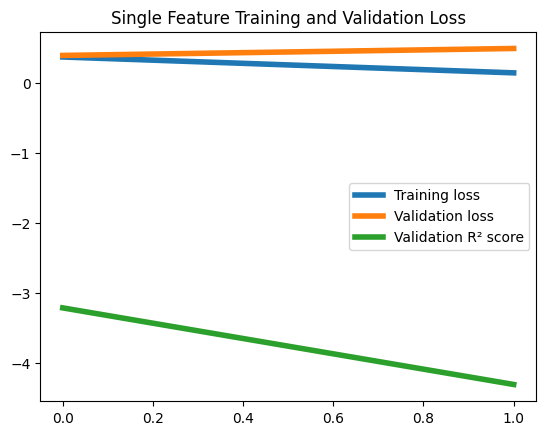

In [167]:
print(single_feature_history.history.keys())

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_r2_score = history.history['val_r2_score']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, lw=4, label='Training loss')
    plt.plot(epochs, val_loss, lw=4, label='Validation loss')
    plt.plot(epochs, val_r2_score, lw=4, label='Validation R² score')
    plt.title(title)
    plt.legend()
    #plt.ylim([0,0.05])

    plt.show()
    
plot_train_history(single_feature_history, 'Single Feature Training and Validation Loss')

In [168]:
y_hat = single_feature_model.predict(x_test_single)

49/49 [==============================] - 4s 74ms/step


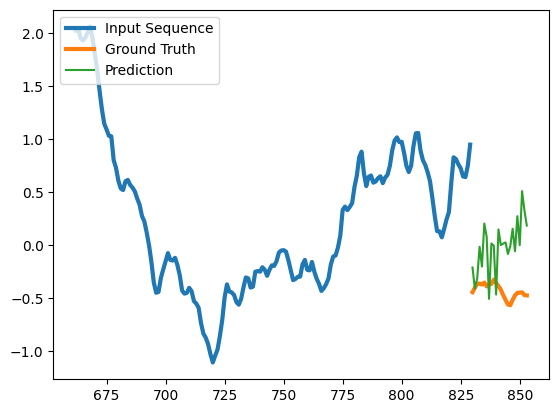

In [188]:
# prediction starting point.
predctStartPt = 830

t = np.arange(y.shape[0])

predctPt = predctStartPt-past_history
#predctPt = 0

plt.figure()

plt.plot(t[predctPt:past_history+predctPt], x_test_single[predctPt,:,11], lw=3, label="Input Sequence")
plt.plot(t[past_history+predctPt:past_history+predctPt+future_target], y_test_single[predctPt], lw=3, label="Ground Truth")
plt.plot(t[past_history+predctPt:past_history+predctPt+future_target], y_hat[predctPt], label="Prediction")
plt.legend(loc='upper left')
#plt.xlim([850, 980])
#plt.ylim([0,1])

plt.show()